# CNN-BiLSTM-Attention Model for Time-Series Research Project 
- Researched by Shane Stoll
- Advised by Uzma Mushtaque

# Libraries to import

In [9]:
from datetime import datetime
import os
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, SimpleRNN, GRU, Dense, Dropout, Bidirectional,
    Conv1D, MaxPooling1D, Flatten, Input, Attention, Concatenate, Reshape
)
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta, SGD
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pandas_ta as ta
from projectpro import model_snapshot, checkpoint

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Steps to Implement the CNN-BiLSTM-Attention Model

## 1. Preprocessing the Stock Data
- Normalize the dataset using Min-Max scaling.
- Reshape the data to fit the CNN input format.

In [10]:
def load_and_preprocess_data(filepath, column='High', 
                             window_size=60,
                             train_start='2010-01-01', 
                             train_end='2021-12-31'):
    """
    Loads the dataset, applies consistent scaling and sequence splitting
    based on fixed date ranges (like in base models).
    
    Returns:
        X_train, y_train, X_test, y_test, scaler
    """
    # Load and parse the dataset
    data = pd.read_csv(filepath, index_col='Date', parse_dates=True)
    data = data[[column]]

    # Split data based on date ranges
    train_data = data.loc[train_start:train_end].values
    test_data = data.loc[train_end:].values  # Test data starts right after training

    # Scale the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_data)
    test_scaled = scaler.transform(test_data)

    # Function to create sliding sequences
    def split_sequence(sequence, n_steps):
        X, y = [], []
        for i in range(len(sequence) - n_steps):
            X.append(sequence[i:i + n_steps])
            y.append(sequence[i + n_steps])
        return np.array(X), np.array(y)

    # Create training and testing sequences
    X_train, y_train = split_sequence(train_scaled, window_size)
    X_test, y_test = split_sequence(test_scaled, window_size)

    # Reshape for model input (samples, time steps, features)
    X_train = X_train.reshape((X_train.shape[0], window_size, 1))
    X_test = X_test.reshape((X_test.shape[0], window_size, 1))

    return X_train, y_train, X_test, y_test, scaler


## 2. CNN for Feature Extraction
- Use 1D convolutional layers to capture short-term trends.
- Apply MaxPooling to reduce dimensionality.

In [11]:
# CNN Model for Feature Extraction
def build_cnn(input_shape):
    cnn_input = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(cnn_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    cnn_model = Model(inputs=cnn_input, outputs=x)
    return cnn_model

## 3. Bi-Directional LSTM for Temporal Dependencies
- Implement Bidirectional LSTM (BiLSTM) to capture sequential patterns in both forward and backward directions.
- Apply Dropout to prevent overfitting.

In [12]:
# Bi-LSTM Model (Reusing Existing Function)
def build_bilstm(n_steps=60, units=300, dropout_rate=0.3):
    bilstm_input = Input(shape=(n_steps, 1))
    x = Bidirectional(LSTM(units, activation='relu', return_sequences=True))(bilstm_input)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(units, activation='relu', return_sequences=True))(x)
    bilstm_model = Model(inputs=bilstm_input, outputs=x)
    return bilstm_model

## 4. Attention Mechanism
- Add an attention layer to focus on the most important time steps.
- Improve the interpretability of the model by weighting significant time points.

In [13]:
from tensorflow.keras.layers import Dense, Multiply, Permute
from tensorflow.keras.layers import Attention

def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Flatten()(attention)

## 5. Fully Connected Output Layer
- Use a Dense layer with a single output neuron to predict the stock price.

In [14]:
# CNN-BiLSTM-Attention Hybrid Model
def build_hybrid_model(n_steps=60, units=300, dropout_rate=0, learning_rate=0.0005):
    input_shape = (n_steps, 1)
    
    # Build CNN and BiLSTM models
    cnn_model = build_cnn(input_shape)
    bilstm_model = build_bilstm(n_steps, units, dropout_rate)

    # Attention Mechanism
    attention_out = attention_layer(bilstm_model.output)

    # Concatenating CNN and BiLSTM outputs
    merged = Concatenate()([cnn_model.output, attention_out])
    output_layer = Dense(1)(merged)

    # Final Model
    model = Model(inputs=[cnn_model.input, bilstm_model.input], outputs=output_layer)
    optimizer = RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

## 6. Compile and Train the Model
- Use an optimizer such as RMSprop or Adam.
- Evaluate performance using MSE, RMSE, MAE, and MAPE.

In [15]:
# Train the Model
def train_hybrid_model(model, X_train, y_train, X_test, y_test, epochs=200, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        [X_train, X_train], y_train, 
        epochs=epochs, batch_size=batch_size,
        validation_data=([X_test, X_test], y_test),
        callbacks=[early_stopping]
    )
    
    return model, history

In [16]:
# Evaluate and Plot Predictions
def evaluate_model(model, X_test, y_test, scaler, title="Hybrid Model Stock Price Prediction"):
    predictions = model.predict([X_test, X_test])
    predictions = scaler.inverse_transform(predictions)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = np.mean((predictions - y_test_scaled)**2)
    mae = np.mean(abs(predictions - y_test_scaled))
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((predictions - y_test_scaled) / y_test_scaled)) * 100

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Percentage Error: {mape}%")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_scaled, label="Actual Prices")
    plt.plot(predictions, label="Predicted Prices", linestyle='dashed', color='red')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

    return mse, mae, rmse, mape

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 238ms/step - loss: 0.0038 - val_loss: 0.0886
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - loss: 6.5370e-04 - val_loss: 0.0490
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 257ms/step - loss: 5.6095e-04 - val_loss: 0.0289
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - loss: 4.4075e-04 - val_loss: 0.0301
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - loss: 4.3191e-04 - val_loss: 0.0237
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - loss: 2.8108e-04 - val_loss: 0.0193
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step - loss: 2.8196e-04 - val_loss: 0.0353
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - loss: 1.9168e-04 - val_loss: 0.0229
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step - loss: 2.1499e-04 - val_loss: 0.0112
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 257ms/step - loss: 2.1347e-04 - val_loss: 0.0101
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - loss: 2.1058e-04 - val_los

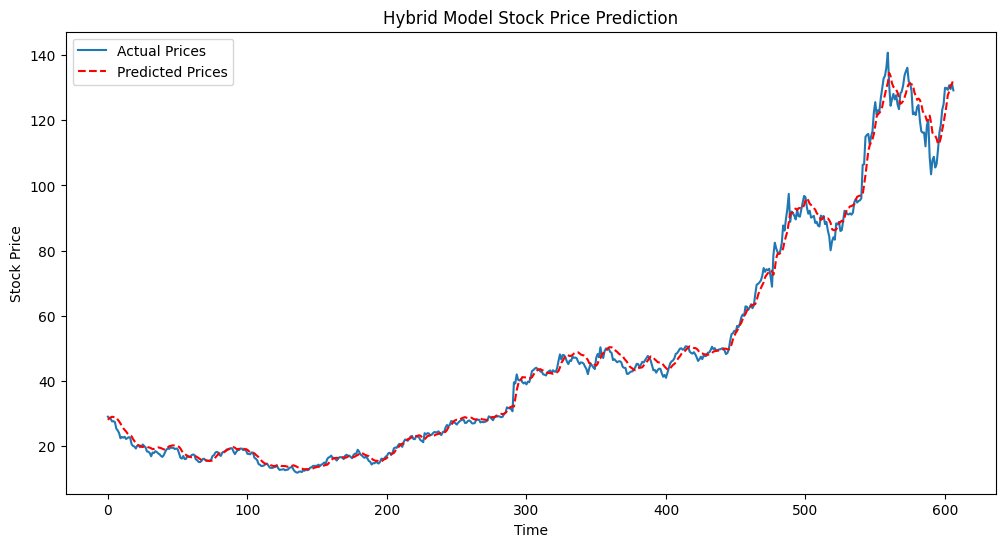

In [17]:
# Run the Hybrid Model on Stock Data
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data('nvidia_stock_data.csv')

    hybrid_model = build_hybrid_model()
    hybrid_model, history = train_hybrid_model(hybrid_model, X_train, y_train, X_test, y_test)

    evaluate_model(hybrid_model, X_test, y_test, scaler)

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 27s 258ms/step - loss: 0.0049 - val_loss: 0.0112
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - loss: 9.6590e-04 - val_loss: 0.0051
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - loss: 9.2971e-04 - val_loss: 0.0061
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - loss: 6.1834e-04 - val_loss: 0.0027
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - loss: 4.3192e-04 - val_loss: 0.0030
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - loss: 4.7293e-04 - val_loss: 0.0024
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - loss: 3.6958e-04 - val_loss: 0.0015
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - loss: 3.4781e-04 - val_loss: 0.0015
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - loss: 3.2361e-04 - val_loss: 0.0013
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - loss: 3.3189e-04 - val_loss: 0.0012
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - loss: 2.7008e-04 - val_los

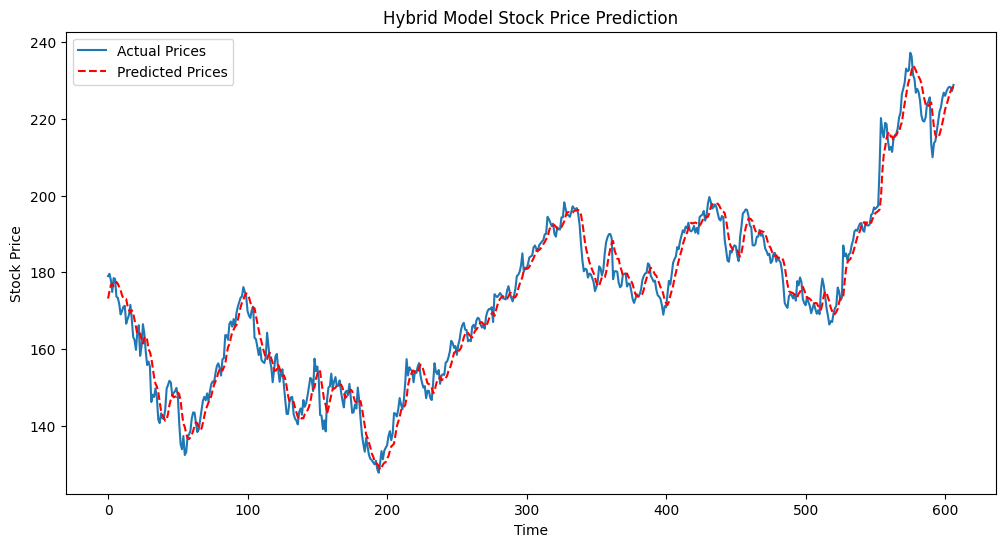

In [18]:
# Run the Hybrid Model on Stock Data
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data('apple_stock_data.csv')

    hybrid_model = build_hybrid_model()
    hybrid_model, history = train_hybrid_model(hybrid_model, X_train, y_train, X_test, y_test)

    evaluate_model(hybrid_model, X_test, y_test, scaler)

Epoch 1/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 267ms/step - loss: 0.0043 - val_loss: 0.0143
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 269ms/step - loss: 7.6280e-04 - val_loss: 0.0094
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - loss: 8.7544e-04 - val_loss: 0.0029
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - loss: 4.6190e-04 - val_loss: 0.0020
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - loss: 4.6862e-04 - val_loss: 0.0029
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 276ms/step - loss: 3.7376e-04 - val_loss: 0.0057
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - loss: 3.9187e-04 - val_loss: 0.0016
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - loss: 3.8212e-04 - val_loss: 0.0047
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - loss: 2.8662e-04 - val_loss: 0.0013
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 276ms/step - loss: 2.5082e-04 - val_loss: 0

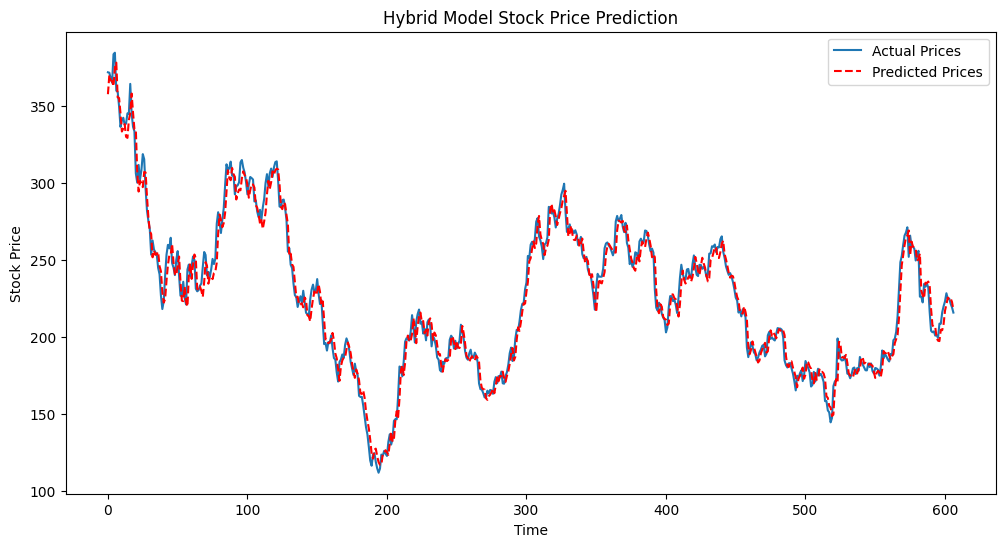

In [19]:
# Run the Hybrid Model on Stock Data
if __name__ == "__main__":
    X_train, y_train, X_test, y_test, scaler = load_and_preprocess_data('tesla_stock_data.csv')

    hybrid_model = build_hybrid_model()
    hybrid_model, history = train_hybrid_model(hybrid_model, X_train, y_train, X_test, y_test)

    evaluate_model(hybrid_model, X_test, y_test, scaler)